This notebook analyzes on-chain USDC activity on Ethereum over a recent 30-day window.
The goal is to demonstrate how stablecoin transaction data can be collected, cleaned, and analyzed using public blockchain APIs, and to highlight key limitations of high-frequency on-chain data.

Transaction data is retrieved using the Etherscan API for ERC-20 token transfers involving the USDC contract on Ethereum. Due to API constraints, the analysis focuses on a recent 30-day window.

## PHASE 1: Single-Day USDC Transactions (Etherscan)
This section was an attempt to retrieve the last 30 days transactions however it failed due to high frequency of major stablecoins.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:


df = pd.read_csv("../data/usdc_raw_30d_fail.csv")
df.shape


(10000, 21)

In [3]:
# Data Cleaning

# Convert timestamp to datetime
df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit="s")

# Create date column
df["date"] = df["timeStamp"].dt.date

# Convert USDC value from on-chain units (6 decimals)
df["usdc_amount"] = df["value"].astype(float) / 1_000_000

df[["timeStamp", "date", "usdc_amount"]].head()


,timeStamp,date,usdc_amount
0,2025-12-18 19:15:23,2025-12-18,95.000000
1,2025-12-18 19:15:23,2025-12-18,638781.773539
2,2025-12-18 19:15:23,2025-12-18,11724.703951
3,2025-12-18 19:15:23,2025-12-18,296.816675
4,2025-12-18 19:15:23,2025-12-18,468.101294


In [4]:
# checking the timeframe of our fetched data
df["date"].min(), df["date"].max()


(datetime.date(2025, 12, 18), datetime.date(2025, 12, 18))

Due to the high transaction frequency of major stablecoins such as USDC, standard blockchain explorer APIs return only the most recent transactions, truncating longer time windows. 

## PHASE 1.5:Multi-Day USDC Transactions via Etherscan 

To extend coverage beyond a single day, I implement a block-by-day querying strategy using the Etherscan API. While this approach allows recovery of multiple days of USDC transactions, high-activity days remain truncated due to API result limits on the free API plan.




In [5]:
#loading the data from the past 30 days 
# Phase 1.5 data load 
df_30d = pd.read_csv("../data/usdc_etherscan_30d.csv")

#cleaning the data 

# Convert timestamp to datetime
df_30d["timeStamp"] = pd.to_datetime(df_30d["timeStamp"], unit="s")

# Create date column
df_30d["date"] = df_30d["timeStamp"].dt.date

# Convert USDC value from on-chain units (6 decimals)
df_30d["usdc_amount"] = df_30d["value"].astype(float) / 1_000_000



In [6]:
#checking the timeframe of our data 
df_30d["date"].min(), df_30d["date"].max()
df_30d.groupby("date").size()


date
2025-12-19    10000
2025-12-20    10000
2025-12-22    10000
2025-12-23    10000
2025-12-24    10000
2025-12-26    10000
2025-12-28    10000
2025-12-29    10000
2025-12-31    10000
2026-01-01    10000
2026-01-02    10000
2026-01-04    10000
2026-01-05    10000
2026-01-07    10000
2026-01-08    10000
2026-01-09    10000
2026-01-10    10000
2026-01-11    10000
2026-01-12    10000
2026-01-14    10000
2026-01-16    10000
dtype: int64

In [7]:
#further data cleaning 
# Remove duplicate transactions (by unique transaction hash)
df_30d = df_30d.drop_duplicates(subset="hash")

# Double-checking that we have no duplicates in our dataset 
df_30d.duplicated(subset="hash").sum()

np.int64(0)

In [8]:
# Check result
df_30d.head()


,blockNumber,timeStamp,hash,nonce,blockHash,from,contractAddress,to,value,tokenName,...,gas,gasPrice,gasUsed,cumulativeGasUsed,input,methodId,functionName,confirmations,date,usdc_amount
0,24249605,2026-01-16 20:12:47,0x79115cd344706eaaeb59b3f30efbeb3c94c537949b92...,29,0xf9662b96ba7bf54ad912b35855218d0220ae2c8d358c...,0x3e7dca5f516df5e40808990774dd5467ca646b95,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xcb0a2b2461989c723d97a853b6ee56751805e4a9,35775761746,USDC,...,125520,2018559049,57472,643738,deprecated,0xa9059cbb,"transfer(address _to, uint256 _value)",7174,2026-01-16,35775.761746
1,24249605,2026-01-16 20:12:47,0xe9d0ed99362e38dfabbc0ee573ef8cc9587a70d0e0de...,361,0xf9662b96ba7bf54ad912b35855218d0220ae2c8d358c...,0x1dc2e936fb10344d124e5ebd5f5ba24290ea5ad8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xcffad3200574698b78f32232aa9d63eabd290703,179032411,USDC,...,100000,2000000000,40360,684098,deprecated,0xa9059cbb,"transfer(address _to, uint256 _value)",7174,2026-01-16,179.032411
2,24249605,2026-01-16 20:12:47,0x7fb93f9c015a8c6df2986de917a53fb4d05b3118280e...,85,0xf9662b96ba7bf54ad912b35855218d0220ae2c8d358c...,0xfed3f706b9c2154f522ea783880867839432ebde,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa023f08c70a23abc7edfc5b6b5e171d78dfc947e,330000000,USDC,...,100000,2000000000,40360,845767,deprecated,0xa9059cbb,"transfer(address _to, uint256 _value)",7174,2026-01-16,330.000000
3,24249605,2026-01-16 20:12:47,0x063da40d481c402184871bb00fe2b582a358a88375ad...,2,0xf9662b96ba7bf54ad912b35855218d0220ae2c8d358c...,0x24c768f52c2d4059e48c88d0c4ee50db927e6ccb,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xcffad3200574698b78f32232aa9d63eabd290703,291802727,USDC,...,100000,2000000000,40360,948448,deprecated,0xa9059cbb,"transfer(address _to, uint256 _value)",7174,2026-01-16,291.802727
4,24249605,2026-01-16 20:12:47,0x024b55c11371054ffbb0ec8c97c5aee9fcebc24f808c...,1,0xf9662b96ba7bf54ad912b35855218d0220ae2c8d358c...,0xf1f0b756dcdfcb2e54834275059cfb43f2fc9d25,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xf29e32fb6622a7d97a832720c755891a7c56c5fd,96890154,USDC,...,60000,1489708456,40360,1117654,deprecated,0xa9059cbb,"transfer(address _to, uint256 _value)",7174,2026-01-16,96.890154


In [9]:
# Aggregate total USDC volume per day for plot purposes 

daily_volume = (
    df_30d.groupby("date")["usdc_amount"]
      .sum()
      .reset_index(name="usdc_volume")
)

# Show the first few rows
daily_volume.head()


,date,usdc_volume
0,2025-12-19,9.125857e+08
1,2025-12-20,3.045488e+08
2,2025-12-22,1.850272e+08
3,2025-12-23,4.555763e+08
4,2025-12-24,4.267328e+08


In [10]:
#checking that the max amount makes sense 
df_30d["usdc_amount"].max()


np.float64(253194296.075839)

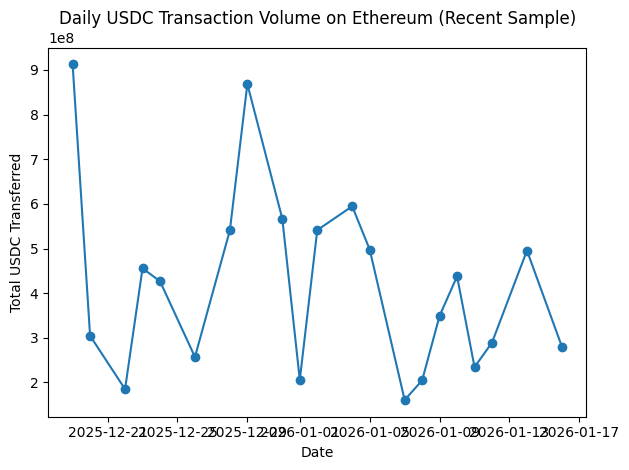

In [11]:
#creating our plot ( x = Date, y = total Daily USDC transferred)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(daily_volume["date"], daily_volume["usdc_volume"], marker="o")
plt.xlabel("Date")
plt.ylabel("Total USDC Transferred")
plt.title("Daily USDC Transaction Volume on Ethereum (Recent Sample)")
plt.tight_layout()
plt.show()


Interpretation of Daily USDC Volume on Ethereum (Last 30 day Sample) 

This figure plots the daily total value of USDC transferred on Ethereum over a recent multi-day period. We observe substantial variation in stablecoin usage across days, with daily volumes ranging from hundreds of millions to over one billion USDC.

The upward trend and sharp increases on certain days suggest that stablecoin transaction activity is not constant, but instead fluctuates meaningfully over time. This pattern is consistent with the idea that stablecoin usage may be influenced by broader market conditions, such as fluctuations in cryptocurrency prices, trading activity, or market volatility.

Motivated by this observation, the next step of the analysis examines whether market-wide crypto conditions, proxied by the price of Ether (ETH), help explain day-to-day variation in USDC transaction volume.

## Market-Wide Crypto Conditions effects on USDC Transaction volume

In [12]:
# Using CoinGecko endpoint to retrieve ETH daily prices for the past 30 days as a proxy for market-wide crypto conditions
url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
params = {
    "vs_currency": "usd",
    "days": 30,      # match your USDC window
    "interval": "daily"
}

response = requests.get(url, params=params)
data = response.json()

# Extract prices
prices = data["prices"]

eth_prices = pd.DataFrame(prices, columns=["timestamp", "eth_price"])
eth_prices["date"] = pd.to_datetime(eth_prices["timestamp"], unit="ms").dt.date
eth_prices = eth_prices[["date", "eth_price"]]

eth_prices.head()

,date,eth_price
0,2025-12-20,2976.796870
1,2025-12-21,2977.162263
2,2025-12-22,3001.600838
3,2025-12-23,3005.786781
4,2025-12-24,2965.193660


In [13]:
# Merge daily USDC volume with ETH prices

merged = pd.merge(
    daily_volume,
    eth_prices,
    on="date",
    how="inner"
)

merged.head()

,date,usdc_volume,eth_price
0,2025-12-20,3.045488e+08,2976.796870
1,2025-12-22,1.850272e+08,3001.600838
2,2025-12-23,4.555763e+08,3005.786781
3,2025-12-24,4.267328e+08,2965.193660
4,2025-12-26,2.570741e+08,2904.252345


In [14]:
merged.shape


(20, 3)

In [15]:
merged


,date,usdc_volume,eth_price
0,2025-12-20,3.045488e+08,2976.796870
1,2025-12-22,1.850272e+08,3001.600838
2,2025-12-23,4.555763e+08,3005.786781
3,2025-12-24,4.267328e+08,2965.193660
4,2025-12-26,2.570741e+08,2904.252345
5,2025-12-28,5.409217e+08,2948.862126
6,2025-12-29,8.682927e+08,2947.859761
7,2025-12-31,5.665708e+08,2970.055474
8,2026-01-01,2.057621e+08,2966.774180
9,2026-01-02,5.411564e+08,3000.419117


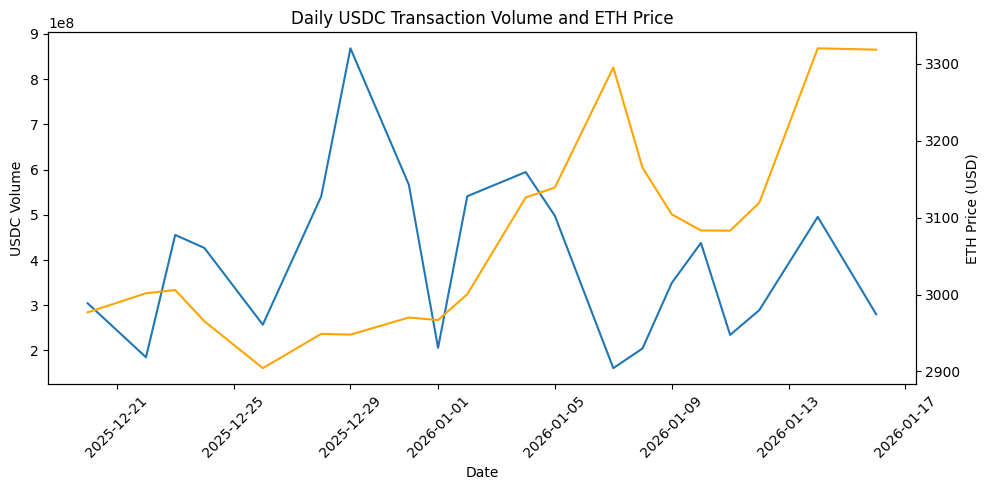

In [16]:
# Plotting USDC volume and ETH price in order to see how these two variables interact with each other if there exists one

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot USDC volume (left axis)
ax1.plot(merged["date"], merged["usdc_volume"], label="USDC Volume")
ax1.set_xlabel("Date")
ax1.set_ylabel("USDC Volume")
ax1.tick_params(axis="x", rotation=45)

# Plot ETH price (right axis)
ax2 = ax1.twinx()
ax2.plot(merged["date"], merged["eth_price"], color="orange", label="ETH Price")
ax2.set_ylabel("ETH Price (USD)")

plt.title("Daily USDC Transaction Volume and ETH Price")
plt.tight_layout()
plt.show()


Figure 1:Daily USDC Transaction Volume and ETH Price

This figure plots daily USDC transaction volume on Ethereum alongside the ETH/USD price. The plot suggests no strong contemporaneous relationship between daily USDC transaction volume and ETH price over this short window. 

USDC volume exhibits sharp daily fluctuations likely driven by exchange and DeFi settlement activity, while ETH prices move more smoothly. This highlights the limitation of same-day correlation analysis and motivates lagged or protocol-specific analysis in later phases.

The analysis is affected by Etherscan API constraints, including missing days that drop out during the merge with ETH prices and a 10,000-transaction daily cap that may truncate high-volume days, biasing observed USDC volume downward.

These limitations motivate the use of indexed blockchain datasets in Phase 2 to enable complete coverage and protocol-level analysis.

In [20]:
# Ordinary least squares (OLS) linear regression with heteroskedasticity-robust (HC1) standard errors
# Define our regression variables
X = merged["eth_price"]
y = merged["usdc_volume"]   

# Add constant (intercept)
X = sm.add_constant(X)

model_robust = sm.OLS(y, X).fit(cov_type="HC1")
model_robust.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            usdc_volume   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.159
Date:                Sat, 17 Jan 2026   Prob (F-statistic):              0.296
Time:                        19:54:50   Log-Likelihood:                -407.35
No. Observations:                  20   AIC:                             818.7
Df Residuals:                      18   BIC:                             820.7
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.487e+09   1.03e+09      1.446      0.148   -5.28e+08     3.5e+09
eth_price  -3.555e+05    3.3e+05     -1.077      0.282      -1e+06    2.92e+05
==============================================================================
Omnibus:                        1.875   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.174
Skew:                           0.591   Prob(JB):                        0.556
Kurtosis:                       2.891   Cond. No.                     7.64e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 7.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Exploratory regression (robust):
I estimate a univariate Ordinary Least Squares (OLS) regression of daily USDC transaction volume on same-day ETH price using heteroskedasticity-robust (HC1) standard errors. The ETH price coefficient is economically small and statistically insignificant (p = 0.282), with very low explanatory power (R² = 0.063), consistent with the exploratory visualization. Interpretation is limited by the short sample window, missing days caused by Etherscan data availability, and truncation of high-activity days due to the API’s 10,000-transaction cap. The large condition number reflects differences in variable scale rather than multicollinearity, as the specification includes a single regressor. Overall, these results suggest that same-day ETH price movements do not meaningfully explain aggregate USDC transaction volume and motivate the use of indexed blockchain data and protocol-level analysis in Phase 2.